# Densité de médecins généralistes par bassin de vie en France métropolitaine

Dans ce notebook, je vais calculer et représenter graphiquement la densité de médecins généralistes par bassin de vie en France métropolitaine. Le bassin de vie est défini par l'INSEE selon ces termes : *le bassin de vie constitue le plus petit territoire sur lequel les habitants ont accès aux équipements et services les plus courants.*

Pour faire le calcul de densité de médecins, j'ai préféré utiliser cette notion de bassin de vie plutôt que de calculer une densité par commune. En effet, une petite commune peut ne pas posséder de médecin mais ses habitants peuvent bénéficier des médecins d'une plus grande commune limitrophe. La notion de bassin de vie me parassait plus appropriée pour faire mes calculs.

### Données

Pour effectuer ce travail de calcul et de représentation graphique, je vais utiliser les fichiers suivants :

- **offre_sante.xlsx** : fichier regroupant le nombre de médecins généralistes par commune (source : Observatoire des territoires / année 2020)
- **georef-france-bassin-vie-2012.geojson** : fichier regroupant les bassins de vie ainsi que les données géographiques correspondantes (source : INSEE / 2012)
- **communes-frmetdrom.geojson** : fichier des différentes communes françaises avec leur données géographiques (source : https://github.com/gregoiredavid/france-geojson)
- **pop_communes.csv** : fichier contenant la population de chaque commune au recensement de 2019 (source : INSEE). La population des communes se trouve aussi dans les données précédentes mais n'ayant pas la date d'actualisation des données, je préfère utiliser un jeu de données actualisé lors du dernier recensement.

Il est à noter que les données sur la population et sur le nombre de médecins ne sont pas de la même année (2020 et 2019). Il on peut penser que ces données changent peu d'une année sur l'autre. Aujourd'hui en 2022, les résultats sont toujours exploitables.

### Jointure des tables

La principale difficulté va être de faire le lien entre les communes et les bassins de vie. En effet, le fichier sur les bassins de vie ne contient pas le nom ou le code postal des communes correspondantes. Pour faire une jointure entre la dataframe des bassins de vie et celle des communes, je vais utiliser une jointure spatiale grâce à la méthode *sjoin* du module geopandas.

La jointure entre la dataframe des médecins par commune et celle des données géographiques des communes sera plus facile à faire car les deux dataframes contiennent le code INSEE de chaque commune.

## 1. Importation et nettoyage des données 

### 1.1 Données des bassins de vie

Je vais tout d'abord importer les données des bassins de vie sous forme d'une geodataframe grâce au module **geopandas**. Puis je supprimerai les bassins de vie d'Outre-Mer car je veux me concentrer sur la France métropolitaine.

In [1]:
# Importation des données sous forme d'une geodataframe
import geopandas as gpd
bassins = gpd.read_file('georef-france-bassin-vie-2012.geojson')
bassins.head()

,bv2012_name_lower,reg_name,bv2012_name_upper,bv2012_type,reg_code,year,bv2012_name,bv2012_area_code,bv2012_code,dep_name,dep_code,bv2012_current_code,geometry
0,bohain-en-vermandois,Hauts-de-France,BOHAIN-EN-VERMANDOIS,bassin de vie 2012,32,2022,Bohain-en-Vermandois,FXX,02095,"Aisne,Nord","02,59",02095,"POLYGON ((3.27573 49.94838, 3.28311 49.94885, ..."
1,hirson,"Grand Est,Hauts-de-France",HIRSON,bassin de vie 2012,"32,44",2022,Hirson,FXX,02381,"Aisne,Ardennes","02,08",02381,"POLYGON ((3.93780 49.91656, 3.94769 49.91056, ..."
2,dompierre-sur-besbre,"Auvergne-Rhône-Alpes,Bourgogne-Franche-Comté",DOMPIERRE-SUR-BESBRE,bassin de vie 2012,"27,84",2022,Dompierre-sur-Besbre,FXX,03102,"Allier,Saône-et-Loire","03,71",03102,"POLYGON ((3.81300 46.38694, 3.81487 46.39595, ..."
3,saint-germain-des-fossés,Auvergne-Rhône-Alpes,SAINT-GERMAIN-DES-FOSSÉS,bassin de vie 2012,84,2022,Saint-Germain-des-Fossés,FXX,03236,Allier,03,03236,"POLYGON ((3.48011 46.26620, 3.48145 46.25895, ..."
4,briançon,Provence-Alpes-Côte d'Azur,BRIANÇON,bassin de vie 2012,93,2022,Briançon,FXX,05023,Hautes-Alpes,05,05023,"POLYGON ((6.66455 44.79523, 6.67399 44.79699, ..."


On remarque que la table contient les numéros de départements dans lesquels se trouvent chaque bassin de vie. Pour supprimer les BV d'Outre-Mer, il suffit de supprimer les lignes dont les codes des DOM sont présents dans la colonne *dep_code*.

In [2]:
# Liste des dpts à supprimer
dpts_drop=['971','972','973','974','975','976']

# Pour chaque dpt, on supprime les lignes correspondantes
for dep in dpts_drop:
    bassins.drop(bassins.loc[bassins['dep_code'].str.contains(dep)].index,inplace=True)

Dans cette table, je n'aurai pas besoin de toutes les colonnes. Je vais ne garder que celles qui seront nécessaires.

In [3]:
cols_a_garder = ['bv2012_name_upper', 'bv2012_code', 'geometry']
bassins = bassins[cols_a_garder]

Regardons maintenant s'il y a des données manquantes dans la table, des doublons, des données à transformer.

In [4]:
bassins.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1641 entries, 0 to 1662
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   bv2012_name_upper  1641 non-null   object  
 1   bv2012_code        1641 non-null   object  
 2   geometry           1641 non-null   geometry
dtypes: geometry(1), object(2)
memory usage: 51.3+ KB


Aucune donnée manquante, les données des colonnes sont de types voulus.

In [5]:
bassins[bassins.duplicated()]

,bv2012_name_upper,bv2012_code,geometry


Il n'y a pas de données en doublon. 

Cette table semble prête à être utilisée.

### 1.2 Données géographiques des communes

Là aussi, je vais importer les données à l'aide du module geopandas.

In [6]:
communes = gpd.read_file('commune-frmetdrom.geojson')
communes.head()

,ID,INSEE_COM,NOM,NOM_M,STATUT,INSEE_REG,INSEE_DEP,INSEE_CAN,INSEE_ARR,SIREN_EPCI,POPULATION,TYPE,geometry
0,COMMUNE_0000000009726955,59668,Zuydcoote,ZUYDCOOTE,Commune simple,32,59,17,4,245900428,1601,COM,"POLYGON ((2.49286 51.07342, 2.49271 51.07340, ..."
1,COMMUNE_0000000009726956,59340,Leffrinckoucke,LEFFRINCKOUCKE,Commune simple,32,59,17,4,245900428,4207,COM,"POLYGON ((2.46625 51.06674, 2.46581 51.06663, ..."
2,COMMUNE_0000000009726957,59260,Ghyvelde,GHYVELDE,Commune simple,32,59,17,4,245900428,4131,COM,"POLYGON ((2.52222 51.01007, 2.52267 51.00923, ..."
3,COMMUNE_0000000009726958,59107,Bray-Dunes,BRAY-DUNES,Commune simple,32,59,17,4,245900428,4495,COM,"POLYGON ((2.50693 51.06050, 2.50932 51.06075, ..."
4,COMMUNE_0000000009726959,59605,Uxem,UXEM,Commune simple,32,59,12,4,200040954,1443,COM,"POLYGON ((2.51650 51.01992, 2.51604 51.01977, ..."


In [7]:
#Suppression des communes d'outre-mer
communes = communes[~(communes['INSEE_DEP'].str.startswith('97'))]

Comme pour les bassins de vie, je vais supprimer les colonnes qui ne m'intéressent pas.

In [8]:
cols_a_garder = ['INSEE_COM', 'NOM', 'INSEE_DEP', 'POPULATION', 'geometry']
communes = communes[cols_a_garder]

Inspectons maintenant les données.

In [9]:
communes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 34868 entries, 0 to 34996
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   INSEE_COM   34868 non-null  object  
 1   NOM         34868 non-null  object  
 2   INSEE_DEP   34868 non-null  object  
 3   POPULATION  34868 non-null  int64   
 4   geometry    34868 non-null  geometry
dtypes: geometry(1), int64(1), object(3)
memory usage: 1.6+ MB


Il n'y a pas de données manquantes et il n'y a pas de problème de type de données.

In [10]:
communes[communes.duplicated(subset=['INSEE_COM'])]

,INSEE_COM,NOM,INSEE_DEP,POPULATION,geometry


Il n'y a pas de données en doublon.

### 1.3 Population des communes

In [11]:
import pandas as pd

#Dans le fichier csv, les noms de colonnes se trouvent à la deuxième ligne
pop_com = pd.read_csv('pop_communes.csv', sep=';', header=2)
pop_com.head()

,Code,Libellé,Nb de familles 2019,Part des familles avec 3 enf. ou plus de - de 25 ans 2019,Population municipale 2019
0,01001,L'Abergement-Clémenciat,240,6,779
1,01002,L'Abergement-de-Varey,79,7,256
2,01004,Ambérieu-en-Bugey,3659,11.7,14134
3,01005,Ambérieux-en-Dombes,521,7.5,1751
4,01006,Ambléon,36,0,112


In [12]:
#Suppression des communes d'outre-mer
pop_com = pop_com[~(pop_com['Code'].str.startswith('97'))]

On ne garde que les colonnes utiles.

In [13]:
pop_com = pop_com[['Code', 'Libellé', 'Population municipale 2019']]

In [14]:
pop_com.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34826 entries, 0 to 34825
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Code                        34826 non-null  object
 1   Libellé                     34826 non-null  object
 2   Population municipale 2019  34826 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


Pas de donnée manquante

In [15]:
pop_com[pop_com.duplicated(subset=['Code'])]

,Code,Libellé,Population municipale 2019


Pas de doublon. En revanche, il s'agit de convertir en int les données de la population.

In [16]:
pop_com['Population municipale 2019'] = pop_com['Population municipale 2019'].astype('int')

Regardons maintenant les statistiques de ces données pour voir s'il y a des valeurs aberrantes.

In [17]:
pop_com['Population municipale 2019'].describe()

count    3.482600e+04
mean     1.869200e+03
std      1.501328e+04
min      0.000000e+00
25%      1.970000e+02
50%      4.540000e+02
75%      1.148000e+03
max      2.165423e+06
Name: Population municipale 2019, dtype: float64

Rien ne semble aberrant à ce stade.

### 1.4 Données sur les médecins généralistes

In [18]:
medecins = pd.ExcelFile('offre_sante.xlsx')
medecins = medecins.parse(0)
medecins.head()

,Observatoire des territoires - ANCT,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,Offre de services de santé (Commune (2021)),NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,Nombre de médecins généralistes libéraux
3,codgeo,libgeo,an,nb_medg
4,01001,L'Abergement-Clémenciat,2020,0


In [19]:
# Suppression des première lignes et redéfinition des noms de colonnes
medecins.columns = medecins.iloc[3]
medecins.drop([0,1,2,3], inplace=True)
medecins = medecins.reset_index(drop=True)
medecins.head()

3,codgeo,libgeo,an,nb_medg
0,01001,L'Abergement-Clémenciat,2020,0
1,01002,L'Abergement-de-Varey,2020,0
2,01004,Ambérieu-en-Bugey,2020,24
3,01005,Ambérieux-en-Dombes,2020,2
4,01006,Ambléon,2020,0


In [20]:
#Suppression des communes d'outre-mer
medecins = medecins[~(medecins['codgeo'].str.startswith('97'))]

Regardons s'il y a du nettoyage de données à faire.

In [21]:
medecins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34836 entries, 0 to 34835
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   codgeo   34836 non-null  object
 1   libgeo   34836 non-null  object
 2   an       34836 non-null  object
 3   nb_medg  34836 non-null  object
dtypes: object(4)
memory usage: 1.3+ MB


Il n'y a pas de données manquantes.

In [22]:
medecins[medecins.duplicated(subset=['codgeo'])]

3,codgeo,libgeo,an,nb_medg


Il n'y a pas de doublons. 

Changeons maintenant le nombre de médecin en type *int* et observons les statistiques de cette colonne.

In [23]:
medecins['nb_medg'] = medecins['nb_medg'].astype('int')

In [24]:
medecins['nb_medg'].describe()

count    34836.000000
mean         1.683574
std         17.837012
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max       2515.000000
Name: nb_medg, dtype: float64

Il n'y a rien à signaler.

### 1.5 Problème du nombre de communes

En regardant les informations des 3 dernières dataframes, on s'aperçoit que le nombre de lignes (donc de communes) est différents. Manque-t-il des communes de France métropolitaine dans certaines tables ?

In [25]:
medecins[~(medecins['codgeo'].isin(pop_com['Code']))]

3,codgeo,libgeo,an,nb_medg
1058,02695,Saint-Thibaut,2020,0
5193,16010,Ambleville,2020,0
6391,19092,Le Jardin,2020,0
7959,24089,Cazoulès,2020,0
8150,24314,Orliaguet,2020,0
8506,25134,Châtillon-sur-Lison,2020,0
8953,25628,Villers-sous-Montrond,2020,0
9169,26219,Mureils,2020,0
20566,56049,Croixanvec,2020,0
32842,85307,La Faute-sur-Mer,2020,0


Dans la dataframe medecins, les communes qui ne sont pas présentes dans pop_com sont des communes à 0 médecin. De plus, après recherche sur le web, il s'agit d'anciennes communes qui ont été intégrées à d'autres communes. Elles sont donc comptabilisées dans la dataframe pop_com (j'ai pu le vérifier même si je ne l'expose pas ici).

In [26]:
communes[~(communes['INSEE_COM'].isin(pop_com['Code']))]

,INSEE_COM,NOM,INSEE_DEP,POPULATION,geometry
34952,75120,Paris 20e Arrondissement,75,194994,"POLYGON ((2.41633 48.84937, 2.41632 48.84940, ..."
34953,75119,Paris 19e Arrondissement,75,184573,"POLYGON ((2.37704 48.87211, 2.37719 48.87217, ..."
34954,75111,Paris 11e Arrondissement,75,145208,"POLYGON ((2.37682 48.87201, 2.37622 48.87179, ..."
34955,75118,Paris 18e Arrondissement,75,192468,"POLYGON ((2.36534 48.90175, 2.36401 48.90172, ..."
34956,75117,Paris 17e Arrondissement,75,166543,"POLYGON ((2.32739 48.88358, 2.32736 48.88367, ..."
34957,75110,Paris 10e Arrondissement,75,86472,"POLYGON ((2.36445 48.88438, 2.36428 48.88439, ..."
34958,75109,Paris 9e Arrondissement,75,60026,"POLYGON ((2.32654 48.86969, 2.32800 48.86992, ..."
34959,75108,Paris 8e Arrondissement,75,35655,"POLYGON ((2.32707 48.88344, 2.32693 48.88341, ..."
34960,75103,Paris 3e Arrondissement,75,34025,"POLYGON ((2.35088 48.86182, 2.35165 48.86164, ..."
34961,75102,Paris 2e Arrondissement,75,21595,"POLYGON ((2.34703 48.87083, 2.34674 48.87088, ..."


Dans la dataframe communes, les communes non présentes dans pop_com sont des arrondissements de grandes villes. Cela ne pose pas de problème non plus s'il existe une ligne avec la commune entière (polygone regroupant tous les arrondissements). En effet, cette dataframe ne servira qu'à obtenir les données géographiques des communes.

In [27]:
print(medecins[medecins['codgeo']=='75101'])
print(pop_com[pop_com['Code']=='75101'])

Empty DataFrame
Columns: [codgeo, libgeo, an, nb_medg]
Index: []
Empty DataFrame
Columns: [Code, Libellé, Population municipale 2019]
Index: []


On s'aperçoit que dans les deux autres dataframes, les arrondissements ne sont pas inclus. Ce sont les villes entières qui sont comptabilisées. Cela va poser problème lors des jointures de tables.

Pour pouvoir faire la jointure entre medecins, pop_com et communes, il faut que les villes de Marseille, Paris et Lyon aient le même code dans chaque table. Je vais donc regarder leur code dans les tables medecins et pop_com.

In [28]:
print(medecins[medecins['libgeo']=='Paris'])
print(pop_com[pop_com['Libellé']=='Paris'])
print(medecins[medecins['libgeo']=='Lyon'])
print(pop_com[pop_com['Libellé']=='Lyon'])
print(medecins[medecins['libgeo']=='Marseille'])
print(pop_com[pop_com['Libellé']=='Marseille'])

3     codgeo libgeo    an  nb_medg
29269  75056  Paris  2020     2515
        Code Libellé  Population municipale 2019
29260  75056   Paris                     2165423
3     codgeo libgeo    an  nb_medg
27105  69123   Lyon  2020      687
        Code Libellé  Population municipale 2019
27096  69123    Lyon                      522969
3    codgeo     libgeo    an  nb_medg
4347  13055  Marseille  2020     1179
       Code    Libellé  Population municipale 2019
4346  13055  Marseille                      870731


Les codes sont donc les suivantes :
- Paris : 75056
- Lyon : 69123
- Marseille : 13055

Je vais remplacer les codes des arrondissements par ces codes dans communes.

In [29]:
arrondissements_paris = (communes['NOM'].str.contains('Paris')) & (communes['NOM'].str.contains('Arrondissement'))
arrondissements_mars = (communes['NOM'].str.contains('Marseille')) & (communes['NOM'].str.contains('Arrondissement'))
arrondissements_lyon = (communes['NOM'].str.contains('Lyon')) & (communes['NOM'].str.contains('Arrondissement'))

communes.loc[arrondissements_paris,'INSEE_COM']='75056'
communes.loc[arrondissements_lyon,'INSEE_COM']='69123'
communes.loc[arrondissements_mars,'INSEE_COM']='13055'

In [30]:
communes[communes['NOM'].str.contains('Arrondissement')]

,INSEE_COM,NOM,INSEE_DEP,POPULATION,geometry
34952,75056,Paris 20e Arrondissement,75,194994,"POLYGON ((2.41633 48.84937, 2.41632 48.84940, ..."
34953,75056,Paris 19e Arrondissement,75,184573,"POLYGON ((2.37704 48.87211, 2.37719 48.87217, ..."
34954,75056,Paris 11e Arrondissement,75,145208,"POLYGON ((2.37682 48.87201, 2.37622 48.87179, ..."
34955,75056,Paris 18e Arrondissement,75,192468,"POLYGON ((2.36534 48.90175, 2.36401 48.90172, ..."
34956,75056,Paris 17e Arrondissement,75,166543,"POLYGON ((2.32739 48.88358, 2.32736 48.88367, ..."
34957,75056,Paris 10e Arrondissement,75,86472,"POLYGON ((2.36445 48.88438, 2.36428 48.88439, ..."
34958,75056,Paris 9e Arrondissement,75,60026,"POLYGON ((2.32654 48.86969, 2.32800 48.86992, ..."
34959,75056,Paris 8e Arrondissement,75,35655,"POLYGON ((2.32707 48.88344, 2.32693 48.88341, ..."
34960,75056,Paris 3e Arrondissement,75,34025,"POLYGON ((2.35088 48.86182, 2.35165 48.86164, ..."
34961,75056,Paris 2e Arrondissement,75,21595,"POLYGON ((2.34703 48.87083, 2.34674 48.87088, ..."


Les codes ont bien été remplacés. Cependant, lors des jointures avec les autres tables, on aura autant de lignes que d'arrondissements avec la même population et le même nombre de médecins sur chaque ligne. Quand il sera temps d'aggréger les données, cela posera problème. Je vais donc ne garder qu'une ligne pour chacune des villes de Paris, Lyon et Marseille.

On pourrait penser que cette opération est problématique pour les contours géographiques. Mais la méthode que je vais utiliser pour joindre mes tables à celle des bassins de population ne nécessite de connaître qu'un seul polygone composant un arrondissement de chaque ville. Il n'y aura donc pas de problème.

In [31]:
communes.loc[arrondissements_paris,'NOM']='Paris'
communes.loc[arrondissements_lyon,'NOM']='Lyon'
communes.loc[arrondissements_mars,'NOM']='Marseille'

communes.drop_duplicates(subset=['INSEE_COM','NOM'], inplace=True)

In [32]:
communes.loc[communes['INSEE_COM'].isin(['75056', '69123', '13055'])]

,INSEE_COM,NOM,INSEE_DEP,POPULATION,geometry
34952,75056,Paris,75,194994,"POLYGON ((2.41633 48.84937, 2.41632 48.84940, ..."
34972,69123,Lyon,69,51983,"POLYGON ((4.81258 45.77197, 4.81231 45.77246, ..."
34981,13055,Marseille,13,91358,"POLYGON ((5.41084 43.31492, 5.41150 43.31484, ..."


Nous avons maintenant une ligne pour chacune des trois lignes. La population n'est pas la bonne mais ce n'est pas grave car j'utiliserai la population de la table *pop_com*. Si nous regardons maintenant le nombre de communes dans chaqe table, il est le même sauf pour *medecins* mais nous avons vu plus haut que ce n'est pas un problème.

In [33]:
print(pop_com.shape[0])
print(communes.shape[0])
print(medecins.shape[0])

34826
34826
34836


## 2. Jointures des dataframes

Les données se situent dans 4 dataframes différents. Pour les exploiter, il va falloir opérer des jointures sur ces dataframes. Pour commencer, je vais faire une jointure entre les dataframes *pop_com* et *medecins* qui contiennent la population de chaque commune et le nombre de médecins de chaque commune. Cela se fait facilement par le code INSEE des communes.

In [34]:
med_pop_com = pop_com.merge(medecins, how='left', left_on='Code', right_on='codgeo')
med_pop_com.head()

,Code,Libellé,Population municipale 2019,codgeo,libgeo,an,nb_medg
0,01001,L'Abergement-Clémenciat,779,01001,L'Abergement-Clémenciat,2020,0
1,01002,L'Abergement-de-Varey,256,01002,L'Abergement-de-Varey,2020,0
2,01004,Ambérieu-en-Bugey,14134,01004,Ambérieu-en-Bugey,2020,24
3,01005,Ambérieux-en-Dombes,1751,01005,Ambérieux-en-Dombes,2020,2
4,01006,Ambléon,112,01006,Ambléon,2020,0


Je ne vais garder que les colonnes qui sont utiles.

In [35]:
med_pop_com = med_pop_com[['Code', 'Libellé', 'Population municipale 2019', 'nb_medg']]

Maintenant, je vais faire une jointure avec les données géographiques des communes. Là-encore, cela va se faire avec le code INSEE des communes.

In [36]:
med_pop_geo_com = med_pop_com.merge(communes, how='inner', left_on='Code', right_on='INSEE_COM')

In [37]:
med_pop_geo_com.head()

,Code,Libellé,Population municipale 2019,nb_medg,INSEE_COM,NOM,INSEE_DEP,POPULATION,geometry
0,01001,L'Abergement-Clémenciat,779,0,01001,L'Abergement-Clémenciat,01,779,"POLYGON ((4.95825 46.15334, 4.95810 46.15342, ..."
1,01002,L'Abergement-de-Varey,256,0,01002,L'Abergement-de-Varey,01,256,"POLYGON ((5.43369 45.98393, 5.43441 45.98428, ..."
2,01004,Ambérieu-en-Bugey,14134,24,01004,Ambérieu-en-Bugey,01,14134,"POLYGON ((5.40942 45.94592, 5.40949 45.94718, ..."
3,01005,Ambérieux-en-Dombes,1751,2,01005,Ambérieux-en-Dombes,01,1751,"POLYGON ((4.94292 45.97974, 4.94275 45.97998, ..."
4,01006,Ambléon,112,0,01006,Ambléon,01,112,"POLYGON ((5.57088 45.75316, 5.57187 45.75200, ..."


Il reste maintenant à faire la jointure avec les données sur les bassins de vie. Le problème est que je ne dispose pas de données communes dans les deux tables *med_pop_geo_com* et *bassins*. Je vais donc faire une **jointure spatiale**. 

Pour opérer cette jointure spatiale, je pourrais prendre les polygones des bassins de vie et les polygones des communes puis faire l'intersection des deux pour savoir quelles communes composent un bassin de vie. Cependant, pour ce faire, il faut utiliser le paramètre *intersects* de la méthode *sjoin* de *geopandas*. Or cette méthode ne sélectionne pas uniquement les communes à l'intérieur d'un bassin de vie mais également toutes les communes ayant une frontière commune avec le bassin de vie. Par exemple, en Côtes-d'Armor, la commune de Lamballe se trouve dans le bassin de vie de Lamballe. Or cette commune a une frontière commune avec le bassin de Saint-Brieuc. En utilisant *intersects*, on retrouvera la commune de Lamballe à la fois dans le bassin de vie de Lamballe et dans celui de Saint-Brieuc, ce qui faussera les données.

**Par conséquent, pour faire la jointure spatiale, j'ai décidé de calculer les coordonnées du centre géographique de chaque commune. Puis je fais une jointure en sélectionnant pour chaque bassin de vie les communes dont le centre se situe dans le bassin de vie à l'aide du paramètre *contains* de *sjoin*.**

In [38]:
# Avec les jointures, on se retrouve avec une dataframe et non une geodataframe. Il faut faire une conversion
med_pop_geo_com = gpd.GeoDataFrame(med_pop_geo_com)

#Création des centres de chaque commune
med_pop_geo_com['centre']=med_pop_geo_com.geometry.centroid

#suppression de la colonne geometry
med_pop_geo_com = med_pop_geo_com.drop('geometry', axis=1)

#Renommer la colonne centre avec le nom geometry (pour la jointure avec sjoin)
med_pop_geo_com.rename(columns={'centre':'geometry'}, inplace=True)
med_pop_geo_com.head()

/tmp/ipykernel_5602/548163638.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  med_pop_geo_com['centre']=med_pop_geo_com.geometry.centroid


,Code,Libellé,Population municipale 2019,nb_medg,INSEE_COM,NOM,INSEE_DEP,POPULATION,geometry
0,01001,L'Abergement-Clémenciat,779,0,01001,L'Abergement-Clémenciat,01,779,POINT (4.92585 46.15372)
1,01002,L'Abergement-de-Varey,256,0,01002,L'Abergement-de-Varey,01,256,POINT (5.42809 46.00961)
2,01004,Ambérieu-en-Bugey,14134,24,01004,Ambérieu-en-Bugey,01,14134,POINT (5.37228 45.96105)
3,01005,Ambérieux-en-Dombes,1751,2,01005,Ambérieux-en-Dombes,01,1751,POINT (4.91197 45.99616)
4,01006,Ambléon,112,0,01006,Ambléon,01,112,POINT (5.59459 45.74988)


In [39]:
# Jointure
df_total = gpd.sjoin(bassins, med_pop_geo_com, how='left', predicate='contains')
df_total.head()

,bv2012_name_upper,bv2012_code,geometry,index_right,Code,Libellé,Population municipale 2019,nb_medg,INSEE_COM,NOM,INSEE_DEP,POPULATION
0,BOHAIN-EN-VERMANDOIS,02095,"POLYGON ((3.27573 49.94838, 3.28311 49.94885, ...",699,02319,Fonsomme,490,0,02319,Fonsomme,02,490
0,BOHAIN-EN-VERMANDOIS,02095,"POLYGON ((3.27573 49.94838, 3.28311 49.94885, ...",691,02310,Fieulaine,248,0,02310,Fieulaine,02,248
0,BOHAIN-EN-VERMANDOIS,02095,"POLYGON ((3.27573 49.94838, 3.28311 49.94885, ...",881,02511,Montigny-en-Arrouaise,295,0,02511,Montigny-en-Arrouaise,02,295
0,BOHAIN-EN-VERMANDOIS,02095,"POLYGON ((3.27573 49.94838, 3.28311 49.94885, ...",703,02323,Fontaine-Uterte,134,0,02323,Fontaine-Uterte,02,134
0,BOHAIN-EN-VERMANDOIS,02095,"POLYGON ((3.27573 49.94838, 3.28311 49.94885, ...",398,02006,Aisonville-et-Bernoville,262,0,02006,Aisonville-et-Bernoville,02,262


Il reste maintenant à calculer la population et le nombre de médecins par BV, puis à calculer la nombre de médecins pour 100 000 habitants. 

In [40]:
df_par_bassin = df_total.groupby(by='bv2012_code').agg({'nb_medg':'sum', 'Population municipale 2019':'sum'})
df_par_bassin['densite']=round(df_par_bassin['nb_medg']/df_par_bassin['Population municipale 2019']*100000,2)
df_par_bassin.head()

,nb_medg,Population municipale 2019,densite
bv2012_code,,,
01004,48,46408,103.43
01033,19,28726,66.14
01034,30,30910,97.06
01053,88,102175,86.13
01093,10,13581,73.63


Pour finir, il n'y a plus qu'à faire une nouvelle jointure entre df_total et df_par_bassin pour obtenir les données géographiques et la densité de médecins dans la même dataframe.

In [41]:
df_total = df_total[['bv2012_name_upper', 'bv2012_code', 'geometry']]
df_par_bassin.rename(columns={'Population municipale 2019':'population'}, inplace=True)

df_final = df_total.merge(df_par_bassin, on='bv2012_code', how='inner')
df_final.head()

,bv2012_name_upper,bv2012_code,geometry,nb_medg,population,densite
0,BOHAIN-EN-VERMANDOIS,02095,"POLYGON ((3.27573 49.94838, 3.28311 49.94885, ...",14,20923,66.91
1,BOHAIN-EN-VERMANDOIS,02095,"POLYGON ((3.27573 49.94838, 3.28311 49.94885, ...",14,20923,66.91
2,BOHAIN-EN-VERMANDOIS,02095,"POLYGON ((3.27573 49.94838, 3.28311 49.94885, ...",14,20923,66.91
3,BOHAIN-EN-VERMANDOIS,02095,"POLYGON ((3.27573 49.94838, 3.28311 49.94885, ...",14,20923,66.91
4,BOHAIN-EN-VERMANDOIS,02095,"POLYGON ((3.27573 49.94838, 3.28311 49.94885, ...",14,20923,66.91


On supprime tous les doublons dus à la jointure.

In [42]:
df_final = df_final.drop_duplicates()
df_final.head()

,bv2012_name_upper,bv2012_code,geometry,nb_medg,population,densite
0,BOHAIN-EN-VERMANDOIS,02095,"POLYGON ((3.27573 49.94838, 3.28311 49.94885, ...",14,20923,66.91
24,HIRSON,02381,"POLYGON ((3.93780 49.91656, 3.94769 49.91056, ...",29,33589,86.34
97,DOMPIERRE-SUR-BESBRE,03102,"POLYGON ((3.81300 46.38694, 3.81487 46.39595, ...",10,12267,81.52
114,SAINT-GERMAIN-DES-FOSSÉS,03236,"POLYGON ((3.48011 46.26620, 3.48145 46.25895, ...",4,5860,68.26
120,BRIANÇON,05023,"POLYGON ((6.66455 44.79523, 6.67399 44.79699, ...",20,18946,105.56


## 3. Exploitation des résultats

In [43]:
df_final['densite'].describe()

count    1641.000000
mean       83.684839
std        32.762660
min         0.000000
25%        63.370000
50%        80.050000
75%        98.680000
max       346.530000
Name: densite, dtype: float64

In [44]:
df_final[df_final['densite']==df_final['densite'].max()]

,bv2012_name_upper,bv2012_code,geometry,nb_medg,population,densite
29844,GRÉOUX-LES-BAINS,04094,"POLYGON ((5.98766 43.69552, 5.98437 43.70868, ...",21,6060,346.53


In [45]:
df_final[df_final['densite']==df_final['densite'].min()]

,bv2012_name_upper,bv2012_code,geometry,nb_medg,population,densite
4609,ARZACQ-ARRAZIGUET,64063,"POLYGON ((-0.42002 43.60324, -0.42830 43.60069...",0,4996,0.0
30740,L'ÎLE-D'YEU,85113,"POLYGON ((-2.33743 46.71910, -2.34382 46.72533...",0,4850,0.0


- La densité moyenne par bassin de vie de médecins généralistes est de 83,68 médecins pour 100 000 habitants.
- La moitié des bassins de vie possède une densité inférieure à 80 médecins pour 100 000 habitants.
- La densité maximale est de 346,53 médecins pour 100 000 habitants. Elle est atteinte dans le bassin de vie de Gréoux-les-bains (04)
- La densité minimale est de 0 (Île d'Yeu et Arzacq-Arraziguet)

Je vais maintenant faire une carte choroplèthe de ces densités de médecins. Pour cela, je vais regrouper les bassins de vie par classe. La délimitation des classes va se faire par quartiles.

In [46]:
df_final['classe'] = pd.qcut(df_final['densite'], 4, ['0 - 63,7', '63,7 - 80', '80 - 98,7', '+98,7'])
df_final.head()

,bv2012_name_upper,bv2012_code,geometry,nb_medg,population,densite,classe
0,BOHAIN-EN-VERMANDOIS,02095,"POLYGON ((3.27573 49.94838, 3.28311 49.94885, ...",14,20923,66.91,"63,7 - 80"
24,HIRSON,02381,"POLYGON ((3.93780 49.91656, 3.94769 49.91056, ...",29,33589,86.34,"80 - 98,7"
97,DOMPIERRE-SUR-BESBRE,03102,"POLYGON ((3.81300 46.38694, 3.81487 46.39595, ...",10,12267,81.52,"80 - 98,7"
114,SAINT-GERMAIN-DES-FOSSÉS,03236,"POLYGON ((3.48011 46.26620, 3.48145 46.25895, ...",4,5860,68.26,"63,7 - 80"
120,BRIANÇON,05023,"POLYGON ((6.66455 44.79523, 6.67399 44.79699, ...",20,18946,105.56,"+98,7"


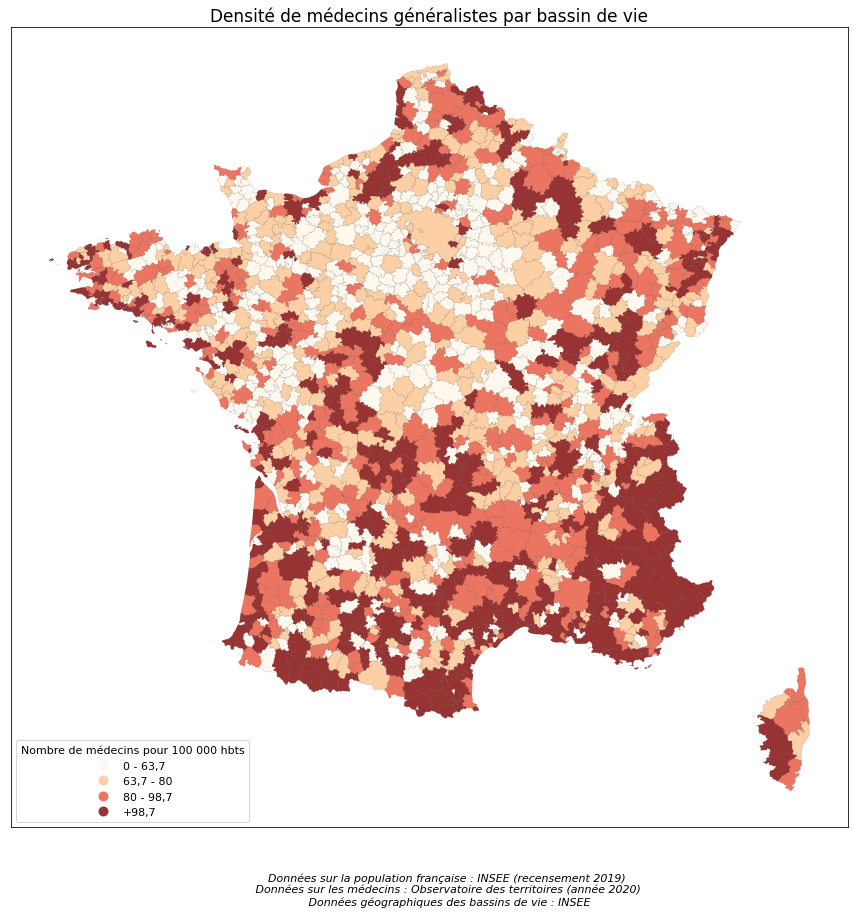

In [47]:
import matplotlib.pyplot as plt

#création de la figure
fig, ax = plt.subplots(1,1, figsize=(15,15))

#Suppression des axes
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

#legende
leg_kwds = {'title' : 'Nombre de médecins pour 100 000 hbts', 'loc':'lower left', 'fontsize':11, 'title_fontsize':11}

#création de la carte
df_final.plot(ax=ax, column='classe', cmap='OrRd',alpha=0.8, edgecolor='black', linewidth=0.1, legend=True, legend_kwds=leg_kwds)

#titre et notes
plt.title("Densité de médecins généralistes par bassin de vie", fontsize=17)
plt.figtext(0.53, 0.06,
            "Données sur la population française : INSEE (recensement 2019) \n Données sur les médecins : Observatoire des territoires (année 2020) \n Données géographiques des bassins de vie : INSEE",
            style='italic', ha="center", fontsize=11, bbox={"facecolor":"white", "edgecolor":"white","alpha":0.5, "pad":5})

plt.show()

Une fois la carte choroplèthe faite, l'idée est d'ajouter des noms de grandes villes pour mieux situer certaines zones. Je vais donc créer une dataframe des villes et de leurs coordonnées (trouvées sur le web) puis je vais les placer sur la carte.

In [48]:
liste_villes=[{'ville':'Paris', 'lat':48.85341, 'long':2.3488},
             {'ville':'Marseille', 'lat':43.299999, 'long':5.4},
             {'ville':'Lyon', 'lat':45.7640430, 'long':4.8356590},
             {'ville':'Toulouse', 'lat':43.6046520, 'long':1.4442090},
             {'ville':'Bordeaux', 'lat':44.8377890, 'long':-0.5791800},
             {'ville':'Nantes', 'lat':47.2183710, 'long':-1.5536210},
             {'ville':'Lille', 'lat':50.6292500, 'long':3.0572560},
             {'ville':'Strasbourg', 'lat':48.5734053, 'long':7.7521113},
             {'ville':'Brest', 'lat':48.3903940, 'long':-4.4860760},
             {'ville':'Orléans', 'lat':47.90289, 'long': 1.9038900},
             {'ville':'Poitiers', 'lat':46.58333, 'long': 0.33333},
             {'ville':'Caen', 'lat':49.18585, 'long':  -0.35912},
             {'ville':'Ajaccio', 'lat':41.92723, 'long': 8.73462}]

df_villes=pd.DataFrame(liste_villes)
df_villes

,ville,lat,long
0,Paris,48.853410,2.348800
1,Marseille,43.299999,5.400000
2,Lyon,45.764043,4.835659
3,Toulouse,43.604652,1.444209
4,Bordeaux,44.837789,-0.579180
5,Nantes,47.218371,-1.553621
6,Lille,50.629250,3.057256
7,Strasbourg,48.573405,7.752111
8,Brest,48.390394,-4.486076
9,Orléans,47.902890,1.903890


In [49]:
#Transformation de la datframe en geodataframe
gdf_villes = gpd.GeoDataFrame(df_villes, geometry=gpd.points_from_xy(df_villes.long, df_villes.lat))
gdf_villes

,ville,lat,long,geometry
0,Paris,48.853410,2.348800,POINT (2.34880 48.85341)
1,Marseille,43.299999,5.400000,POINT (5.40000 43.30000)
2,Lyon,45.764043,4.835659,POINT (4.83566 45.76404)
3,Toulouse,43.604652,1.444209,POINT (1.44421 43.60465)
4,Bordeaux,44.837789,-0.579180,POINT (-0.57918 44.83779)
5,Nantes,47.218371,-1.553621,POINT (-1.55362 47.21837)
6,Lille,50.629250,3.057256,POINT (3.05726 50.62925)
7,Strasbourg,48.573405,7.752111,POINT (7.75211 48.57341)
8,Brest,48.390394,-4.486076,POINT (-4.48608 48.39039)
9,Orléans,47.902890,1.903890,POINT (1.90389 47.90289)


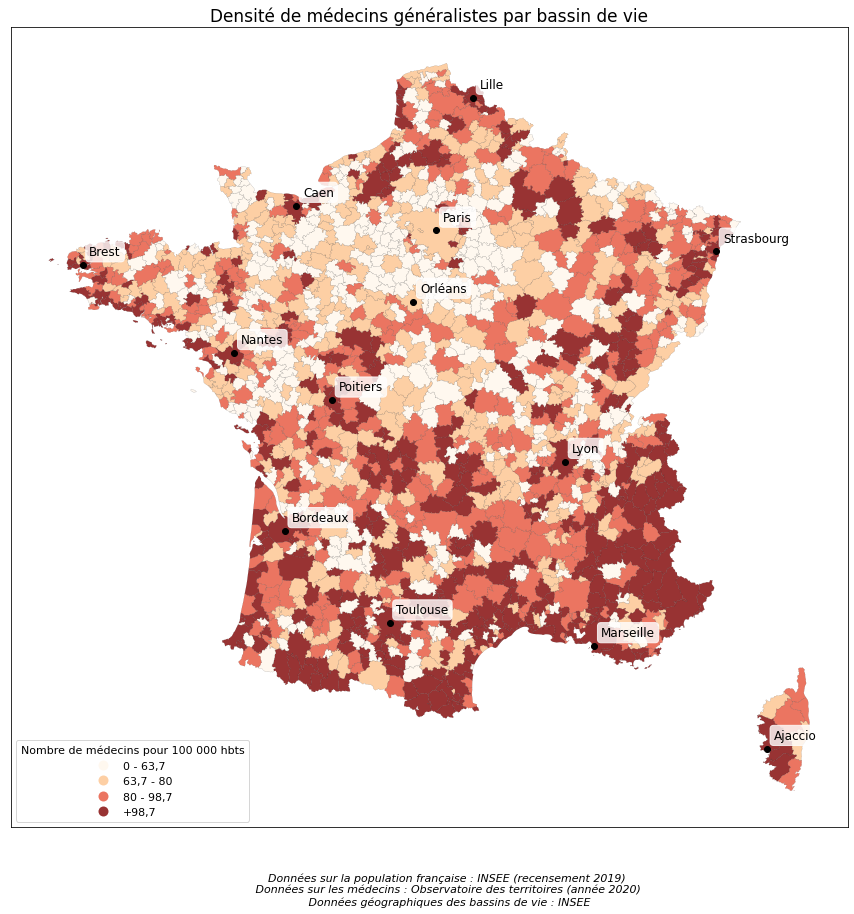

In [50]:
#création de la figure
fig, ax = plt.subplots(1,1, figsize=(15,15))

#Suppression des axes
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

#legende
leg_kwds = {'title' : 'Nombre de médecins pour 100 000 hbts', 'loc':'lower left', 'fontsize':11, 'title_fontsize':11}

#création de la carte
df_final.plot(ax=ax, column='classe', cmap='OrRd',alpha=0.8, edgecolor='black', linewidth=0.1, legend=True, legend_kwds=leg_kwds)

#titre et notes
plt.title("Densité de médecins généralistes par bassin de vie", fontsize=17)
plt.figtext(0.53, 0.06,
            "Données sur la population française : INSEE (recensement 2019) \n Données sur les médecins : Observatoire des territoires (année 2020) \n Données géographiques des bassins de vie : INSEE",
            style='italic', ha="center", fontsize=11, bbox={"facecolor":"white", "edgecolor":"white","alpha":0.5, "pad":5})
# Placement des points
ax.scatter(df_villes.long,df_villes.lat,c='black')
# Placement des noms de villes
bbox=dict(boxstyle="round", alpha=0.8, color='white')
for _,row in df_villes.iterrows():
   ax.text(row['long']+0.13,row['lat']+0.13,row['ville'],fontsize='large', bbox=bbox)

#Récupération de la figure courante pour pouvoir la sauvegarder
fig1=plt.gcf()
fig1.savefig('densité médecins.jpg', bbox_inches='tight', dpi=200)

#Affichage
plt.show()